In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import gurobi_logtools as glt


In [2]:
theta_list = [1e-2, 5e-2]  # the Wasserstein radius. Bonferroni approximation requires small theta for feasibility
epsilon_list = [0.05, 0.025]  # he risk level
gurobi_seed_list = [i for i in range(0, 10000*30, 10000)] 
T_list = [4, 8, 12, 16, 20, 24]
N_WDR_list = [50]
M = 1e5
thread = 4
FGap = 1e-3
timelimit = 3600

In [3]:
param_comb = list(itertools.product(epsilon_list, theta_list, N_WDR_list, T_list))
save_path_root = os.path.join(os.getcwd(), f'Bilevel_results_bigM{int(M)}_thread{int(thread)}')

def convert(n):
    # return the original number if it is not None nor nan
    return n if (n is not None) and (not np.isnan(n)) else np.nan

def n_nonan(n):
    # return the number of non-nan in the list
    return sum([1 for i in n if not np.isnan(i)])

def mynanmean(n):
    # if all nan, return nan; otherwise, return the nanmean
    return np.nan if all(np.isnan(i) for i in n) else np.nanmean(n)

def mynan_geomean(n):
    no_nan_list = [i for i in n if not np.isnan(i)]
    # return the geometric mean of the non-nan list
    if len(no_nan_list) == 0:
        return np.nan
    else:
        res = 1
        for i in no_nan_list:
            res *= i
        print(1, res, 1/len(no_nan_list))
        return res ** (1/len(no_nan_list))

def retrieve_log(log_save_path, nan_flag, obj2compare, FGap, status):
    if not nan_flag:
        if obj2compare != 'proposed':
            if np.isnan(obj2compare):
                obj2compare = -1e9 # any feasible solution is eligible
        # the model needs to be feasible
        log = glt.parse(log_save_path).summary()
        ObjVal = log['ObjVal'].item()
        MIPgap = convert(log['MIPGap'].item())*100
        RunTime = log['Runtime'].item()
        Solvable = (log['SolCount'].item() > 0)
        
        # the first time when a feasible solution comparable to the obj2compare is found
        # find rows with incumbent similar to the obj2compare
        log_progress = glt.parse(log_save_path).progress()
        obj2compare = ObjVal if obj2compare == 'proposed' else obj2compare
        # this is a maximization problem, so the gap calculation is reversed from SUC
        log_selected = log_progress[((obj2compare - log_progress['Incumbent'])/np.abs(obj2compare)) <= FGap]
        if len(log_selected) == 0:
            # no solution with quality similar to the proposed best solution
            time_F = timelimit
        else:
            index = log_selected.index[0]
            time_F = log_progress.loc[index, 'Time']
    else:
        # model infeasible or no feasible solutions found
        ObjVal = np.nan
        MIPgap = np.nan
        RunTime = timelimit if status.item() == 'TIME_LIMIT' else np.nan
        time_F = timelimit if status.item() == 'TIME_LIMIT' else np.nan
        Solvable = False
    return ObjVal, RunTime, MIPgap, time_F, Solvable

def load_results(param_comb, save_path_root, numerical_focus, IntegralityFocus):
    res_df = []
    res_all_df = []
    for param in param_comb:
        epsilon, theta, N, T = param
        bilevel_obj_proposed_list = []
        bilevel_obj_linearforN_list = []
        bilevel_obj_wcvar_list = []
        bilevel_obj_bonferroni_list = []
        
        bilevel_obj_proposed_minus_prop_list = []
        bilevel_obj_linearforN_minus_prop_list = []
        bilevel_obj_wcvar_minus_prop_list = []
        bilevel_obj_bonferroni_minus_prop_list = []
        
        exact_profit_proposed_list = []
        exact_profit_linearforN_list = []
        exact_profit_wcvar_list = []
        exact_profit_bonferroni_list = []
        
        bilevel_obj_exact_profit_diff_proposed_list = []
        bilevel_obj_exact_profit_diff_linearforN_list = []
        bilevel_obj_exact_profit_diff_wcvar_list = []
        bilevel_obj_exact_profit_diff_bonferroni_list = []
        
        exact_profit_proposed_minus_prop_list = []
        exact_profit_linearforN_minus_prop_list = []
        exact_profit_wcvar_minus_prop_list = []
        exact_profit_bonferroni_minus_prop_list = []
        
        reliability_exact_list = []
        reliability_proposed_list = []
        reliability_linearforN_list = []
        reliability_wcvar_list = []
        reliability_bonferroni_list = []
        
        computing_time_proposed_list = []
        computing_time_linearforN_list = []
        computing_time_bonferroni_list = []
        computing_time_wcvar_list = []
        
        computing_time_proposed_F_list = []
        computing_time_linearforN_F_list = []
        computing_time_bonferroni_F_list = []
        computing_time_wcvar_F_list = []
        
        bilevel_gap_proposed_list = []
        bilevel_gap_linearforN_list = []
        bilevel_gap_wcvar_list = []
        bilevel_gap_bonferroni_list = []
        
        Solvable_proposed_list = []
        Solvable_linearforN_list = []
        Solvable_wcvar_list = []
        Solvable_bonferroni_list = []
        
        break_flag = False
        
        # get the result path or all seeds
        res_save_path_proposed_list = []
        res_save_path_linearforN_list = []
        res_save_path_wcvar_list = []
        res_save_path_bonferroni_list = []
        log_save_path_proposed_list = []
        log_save_path_linearforN_list = []
        log_save_path_wcvar_list = []
        log_save_path_bonferroni_list = []
        for gurobi_seed in gurobi_seed_list:
            res_save_path_proposed = os.path.join(save_path_root, f'results_proposed_theta{theta}_epsilon{epsilon}_seed{gurobi_seed}_N{N}_T{T}_numerical_focus{numerical_focus}_IntegralityFocus{IntegralityFocus}.npy')
            res_save_path_linearforN = os.path.join(save_path_root, f'results_linearforN_theta{theta}_epsilon{epsilon}_seed{gurobi_seed}_N{N}_T{T}_numerical_focus{numerical_focus}_IntegralityFocus{IntegralityFocus}.npy')
            res_save_path_wcvar = os.path.join(save_path_root, f'results_wcvar_theta{theta}_epsilon{epsilon}_seed{gurobi_seed}_N{N}_T{T}_numerical_focus{numerical_focus}_IntegralityFocus{IntegralityFocus}.npy')
            res_save_path_bonferroni = os.path.join(save_path_root, f'results_bonferroni_theta{theta}_epsilon{epsilon}_seed{gurobi_seed}_N{N}_T{T}_numerical_focus{numerical_focus}_IntegralityFocus{IntegralityFocus}.npy')
            
            log_save_path_proposed = os.path.join(save_path_root, f'proposed_theta{theta}_epsilon{epsilon}_seed{gurobi_seed}_N{N}_T{T}_numerical_focus{numerical_focus}_IntegralityFocus{IntegralityFocus}.txt')
            log_save_path_linearforN = os.path.join(save_path_root, f'linearforN_theta{theta}_epsilon{epsilon}_seed{gurobi_seed}_N{N}_T{T}_numerical_focus{numerical_focus}_IntegralityFocus{IntegralityFocus}.txt')
            log_save_path_wcvar = os.path.join(save_path_root, f'wcvar_theta{theta}_epsilon{epsilon}_seed{gurobi_seed}_N{N}_T{T}_numerical_focus{numerical_focus}_IntegralityFocus{IntegralityFocus}.txt')
            log_save_path_bonferroni = os.path.join(save_path_root, f'bonferroni_theta{theta}_epsilon{epsilon}_seed{gurobi_seed}_N{N}_T{T}_numerical_focus{numerical_focus}_IntegralityFocus{IntegralityFocus}.txt')
            
            if not os.path.exists(res_save_path_proposed) or not os.path.exists(res_save_path_linearforN) or not os.path.exists(res_save_path_wcvar) or not os.path.exists(res_save_path_bonferroni):
                break_flag = True
                break
            
            # append to list
            res_save_path_proposed_list.append(res_save_path_proposed)
            res_save_path_linearforN_list.append(res_save_path_linearforN)
            res_save_path_wcvar_list.append(res_save_path_wcvar)
            res_save_path_bonferroni_list.append(res_save_path_bonferroni)
            
            log_save_path_proposed_list.append(log_save_path_proposed)
            log_save_path_linearforN_list.append(log_save_path_linearforN)
            log_save_path_wcvar_list.append(log_save_path_wcvar)
            log_save_path_bonferroni_list.append(log_save_path_bonferroni)
            
        if break_flag:
            continue

        
        # load results
        for seed_idx, gurobi_seed in enumerate(gurobi_seed_list):
            res_save_path_proposed = res_save_path_proposed_list[seed_idx]
            res_save_path_linearforN = res_save_path_linearforN_list[seed_idx]
            res_save_path_wcvar = res_save_path_wcvar_list[seed_idx]
            res_save_path_bonferroni = res_save_path_bonferroni_list[seed_idx]
            log_save_path_proposed = log_save_path_proposed_list[seed_idx]
            log_save_path_linearforN = log_save_path_linearforN_list[seed_idx]
            log_save_path_wcvar = log_save_path_wcvar_list[seed_idx]
            log_save_path_bonferroni = log_save_path_bonferroni_list[seed_idx]
            
            res_proposed = np.load(res_save_path_proposed, allow_pickle=True).item()
            res_linearforN = np.load(res_save_path_linearforN, allow_pickle=True).item()
            res_wcvar = np.load(res_save_path_wcvar, allow_pickle=True).item()
            res_bonferroni = np.load(res_save_path_bonferroni, allow_pickle=True).item()
            
            exact_profit_proposed = res_proposed['total_profit (kUSD)']
            reliability_proposed = res_proposed['reliability_test (%)']
            exact_profit_linearforN = res_linearforN['total_profit (kUSD)']
            reliability_linearforN= res_linearforN['reliability_test (%)']
            exact_profit_wcvar = res_wcvar['total_profit (kUSD)']
            reliability_wcvar = res_wcvar['reliability_test (%)']
            exact_profit_bonferroni = res_bonferroni['total_profit (kUSD)']
            reliability_bonferroni = res_bonferroni['reliability_test (%)']
            
            reliability_exact = res_proposed['reliability_test_exact (%)']
            reliability_exact_list.append(reliability_exact)
            
            proposed_status = glt.parse(log_save_path_proposed).summary().Status
            linearforN_status = glt.parse(log_save_path_linearforN).summary().Status
            wcvar_status = glt.parse(log_save_path_wcvar).summary().Status
            bonferroni_status = glt.parse(log_save_path_bonferroni).summary().Status
            
            # check if the proposed is infeasible
            if proposed_status.item() not in ['OPTIMAL', 'TIME_LIMIT']:
                print(f'{proposed_status.item()} proposed: seed={gurobi_seed}, T={T}, theta={theta}, epsilon={epsilon}, N={N}')
            
            
            bilevel_obj_proposed, computing_time_proposed, bilevel_gap_proposed, computing_time_proposed_F, Solvable_proposed = retrieve_log(log_save_path_proposed, nan_flag=np.isnan(exact_profit_proposed), obj2compare='proposed', FGap=FGap, status=proposed_status)
            bilevel_obj_linearforN, computing_time_linearforN, bilevel_gap_linearforN, computing_time_linearforN_F, Solvable_linearforN = retrieve_log(log_save_path_linearforN, nan_flag=np.isnan(exact_profit_linearforN), obj2compare=bilevel_obj_proposed, FGap=FGap, status=linearforN_status)
            bilevel_obj_wcvar, computing_time_wcvar, bilevel_gap_wcvar, computing_time_wcvar_F, Solvable_wcvar = retrieve_log(log_save_path_wcvar, nan_flag=np.isnan(exact_profit_wcvar), obj2compare=bilevel_obj_proposed, FGap=FGap, status=wcvar_status)
            bilevel_obj_bonferroni, computing_time_bonferroni, bilevel_gap_bonferroni, computing_time_bonferroni_F, Solvable_bonferroni = retrieve_log(log_save_path_bonferroni, nan_flag=np.isnan(exact_profit_bonferroni), obj2compare=bilevel_obj_proposed, FGap=FGap, status=bonferroni_status)
            
            if bilevel_obj_proposed < bilevel_obj_linearforN-1e-5:
                print(f'linearforN bilevel obj better than proposed: seed={gurobi_seed}, T={T}, theta={theta}, epsilon={epsilon}, N={N}, proposed bi-obj={bilevel_obj_proposed}, linearforN bi-obj={bilevel_obj_linearforN}, the diff is {bilevel_obj_linearforN - bilevel_obj_proposed}')
                
            if bilevel_obj_proposed < bilevel_obj_wcvar-1e-5:
                print(f'wcvar bilevel obj better than proposed: seed={gurobi_seed}, T={T}, theta={theta}, epsilon={epsilon}, N={N}, proposed bi-obj={bilevel_obj_proposed}, wcvar bi-obj={bilevel_obj_wcvar}, the diff is {bilevel_obj_wcvar - bilevel_obj_proposed}')
            
                
            all_fea_flag = True
                
            bilevel_obj_exact_profit_diff_proposed_list.append(bilevel_obj_proposed - exact_profit_proposed)
            bilevel_obj_exact_profit_diff_linearforN_list.append(bilevel_obj_linearforN - exact_profit_linearforN)
            bilevel_obj_exact_profit_diff_wcvar_list.append(bilevel_obj_wcvar - exact_profit_wcvar)
            bilevel_obj_exact_profit_diff_bonferroni_list.append(bilevel_obj_bonferroni - exact_profit_bonferroni)
                
            bilevel_obj_proposed_list.append(bilevel_obj_proposed if all_fea_flag else np.nan)
            bilevel_obj_linearforN_list.append(bilevel_obj_linearforN if all_fea_flag else np.nan)
            bilevel_obj_wcvar_list.append(bilevel_obj_wcvar if all_fea_flag else np.nan)
            bilevel_obj_bonferroni_list.append(bilevel_obj_bonferroni if all_fea_flag else np.nan)
            
            bilevel_gap_proposed_list.append(bilevel_gap_proposed)
            bilevel_gap_linearforN_list.append(bilevel_gap_linearforN)
            bilevel_gap_wcvar_list.append(bilevel_gap_wcvar)
            bilevel_gap_bonferroni_list.append(bilevel_gap_bonferroni)
            
            exact_profit_proposed_list.append(exact_profit_proposed if all_fea_flag else np.nan)
            exact_profit_linearforN_list.append(exact_profit_linearforN if all_fea_flag else np.nan)
            exact_profit_wcvar_list.append(exact_profit_wcvar if all_fea_flag else np.nan)
            exact_profit_bonferroni_list.append(exact_profit_bonferroni if all_fea_flag else np.nan)
            
            bilevel_obj_proposed_minus_prop_list.append(0 if not np.isnan(bilevel_obj_proposed) else np.nan)
            bilevel_obj_linearforN_minus_prop_list.append(bilevel_obj_linearforN - bilevel_obj_proposed if (not np.isnan(bilevel_obj_proposed)) and (not np.isnan(bilevel_obj_linearforN)) else np.nan)
            bilevel_obj_wcvar_minus_prop_list.append(bilevel_obj_wcvar - bilevel_obj_proposed if (not np.isnan(bilevel_obj_proposed)) and (not np.isnan(bilevel_obj_wcvar)) else np.nan)
            bilevel_obj_bonferroni_minus_prop_list.append(bilevel_obj_bonferroni - bilevel_obj_proposed if (not np.isnan(bilevel_obj_proposed)) and (not np.isnan(bilevel_obj_bonferroni)) else np.nan)
            
            exact_profit_proposed_minus_prop_list.append(0 if not np.isnan(exact_profit_proposed) else np.nan)
            exact_profit_linearforN_minus_prop_list.append(exact_profit_linearforN - exact_profit_proposed if (not np.isnan(exact_profit_proposed)) and (not np.isnan(exact_profit_linearforN)) else np.nan)
            exact_profit_wcvar_minus_prop_list.append(exact_profit_wcvar - exact_profit_proposed if (not np.isnan(exact_profit_proposed)) and (not np.isnan(exact_profit_wcvar)) else np.nan)
            exact_profit_bonferroni_minus_prop_list.append(exact_profit_bonferroni - exact_profit_proposed if (not np.isnan(exact_profit_proposed)) and (not np.isnan(exact_profit_bonferroni)) else np.nan)
            
            reliability_proposed_list.append(reliability_proposed)
            reliability_linearforN_list.append(reliability_linearforN)
            reliability_wcvar_list.append(reliability_wcvar)
            reliability_bonferroni_list.append(reliability_bonferroni)
            
            computing_time_proposed_list.append(computing_time_proposed)
            computing_time_linearforN_list.append(computing_time_linearforN)
            computing_time_wcvar_list.append(computing_time_wcvar)
            computing_time_bonferroni_list.append(computing_time_bonferroni)
            
            computing_time_proposed_F_list.append(computing_time_proposed_F)
            computing_time_linearforN_F_list.append(computing_time_linearforN_F)
            computing_time_wcvar_F_list.append(computing_time_wcvar_F)
            computing_time_bonferroni_F_list.append(computing_time_bonferroni_F)
            
            Solvable_proposed_list.append(Solvable_proposed)
            Solvable_linearforN_list.append(Solvable_linearforN)
            Solvable_wcvar_list.append(Solvable_wcvar)
            Solvable_bonferroni_list.append(Solvable_bonferroni)
            
            # for the proposed method
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta,
                'N': N,
                'T': T,
                'gurobi_seed': gurobi_seed,
                'method': 'SFLA',
                'bilevel_obj': bilevel_obj_proposed_list[-1],
                'exact_profit': exact_profit_proposed_list[-1],
                'bilevel_obj_minus_prop': bilevel_obj_proposed_minus_prop_list[-1],
                'exact_profit_minus_prop': exact_profit_proposed_minus_prop_list[-1],
                'reliability': reliability_proposed_list[-1],
                'computing_time': computing_time_proposed_list[-1],
                'computing_time_F': computing_time_proposed_F_list[-1],
                'status': proposed_status,
                'Solvable': Solvable_proposed_list[-1],
                'bilevel_obj_exact_profit_diff': bilevel_obj_exact_profit_diff_proposed_list[-1]
            }, index=[0]))
            # for the linearforN method
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta,
                'N': N,
                'T': T,
                'gurobi_seed': gurobi_seed,
                'method': 'LA',
                'bilevel_obj': bilevel_obj_linearforN_list[-1],
                'exact_profit': exact_profit_linearforN_list[-1],
                'bilevel_obj_minus_prop': bilevel_obj_linearforN_minus_prop_list[-1],
                'exact_profit_minus_prop': exact_profit_linearforN_minus_prop_list[-1],
                'reliability': reliability_linearforN_list[-1],
                'computing_time': computing_time_linearforN_list[-1],
                'computing_time_F': computing_time_linearforN_F_list[-1],
                'status': linearforN_status,
                'Solvable': Solvable_linearforN_list[-1],
                'bilevel_obj_exact_profit_diff': bilevel_obj_exact_profit_diff_linearforN_list[-1]
            }, index=[0]))
            # for the wcvar method
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta,
                'N': N,
                'T': T,
                'gurobi_seed': gurobi_seed,
                'method': 'W-CVaR',
                'bilevel_obj': bilevel_obj_wcvar_list[-1],
                'exact_profit': exact_profit_wcvar_list[-1],
                'bilevel_obj_minus_prop': bilevel_obj_wcvar_minus_prop_list[-1],
                'exact_profit_minus_prop': exact_profit_wcvar_minus_prop_list[-1],
                'reliability': reliability_wcvar_list[-1],
                'computing_time': computing_time_wcvar_list[-1],
                'computing_time_F': computing_time_wcvar_F_list[-1],
                'status': wcvar_status,
                'Solvable': Solvable_wcvar_list[-1],
                'bilevel_obj_exact_profit_diff': bilevel_obj_exact_profit_diff_wcvar_list[-1]
            }, index=[0]))
            # for the bonferroni method
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta,
                'N': N,
                'T': T,
                'gurobi_seed': gurobi_seed,
                'method': 'Bonferroni',
                'bilevel_obj': bilevel_obj_bonferroni_list[-1],
                'exact_profit': exact_profit_bonferroni_list[-1],
                'bilevel_obj_minus_prop': bilevel_obj_bonferroni_minus_prop_list[-1],
                'exact_profit_minus_prop': exact_profit_bonferroni_minus_prop_list[-1],
                'reliability': reliability_bonferroni_list[-1],
                'computing_time': computing_time_bonferroni_list[-1],
                'computing_time_F': computing_time_bonferroni_F_list[-1],
                'status': bonferroni_status,
                'Solvable': Solvable_bonferroni_list[-1],
                'bilevel_obj_exact_profit_diff': bilevel_obj_exact_profit_diff_bonferroni_list[-1]
            }, index=[0]))

        # append to df
        res_df.append(pd.DataFrame({
            'eps': epsilon, 
            'theta': theta, 
            'N': N, 
            'T': T,
            'bilevel_obj_proposed': mynanmean(bilevel_obj_proposed_list),
            'bilevel_obj_linearforN': mynanmean(bilevel_obj_linearforN_list),
            'bilevel_obj_wcvar': mynanmean(bilevel_obj_wcvar_list),
            'bilevel_obj_bonferroni': mynanmean(bilevel_obj_bonferroni_list),
            'exact_profit_proposed': mynanmean(exact_profit_proposed_list),
            'exact_profit_linearforN': mynanmean(exact_profit_linearforN_list),
            'exact_profit_wcvar': mynanmean(exact_profit_wcvar_list),
            'exact_profit_bonferroni': mynanmean(exact_profit_bonferroni_list),
            'time_proposed': f'{mynanmean(computing_time_proposed_list)}({mynanmean(bilevel_gap_proposed_list)}% {np.sum(Solvable_proposed_list)}/{len(Solvable_proposed_list)})',
            'time_linearforN': f'{mynanmean(computing_time_linearforN_list)}({mynanmean(bilevel_gap_linearforN_list)}% {np.sum(Solvable_linearforN_list)}/{len(Solvable_linearforN_list)})',
            'time_wcvar': f'{mynanmean(computing_time_wcvar_list)}({mynanmean(bilevel_gap_wcvar_list)}% {np.sum(Solvable_wcvar_list)}/{len(Solvable_wcvar_list)})',
            'time_bonferroni':f'{mynanmean(computing_time_bonferroni_list)}({mynanmean(bilevel_gap_bonferroni_list)}% {np.sum(Solvable_bonferroni_list)}/{len(Solvable_bonferroni_list)})',
            'time_linearforN_rel': mynanmean(computing_time_linearforN_list) / mynanmean(computing_time_proposed_list),
            'time_wcvar_rel': mynanmean(computing_time_wcvar_list) / mynanmean(computing_time_proposed_list),
            'time_bonferroni_rel': mynanmean(computing_time_bonferroni_list) / mynanmean(computing_time_proposed_list),
            'reliability_proposed': mynanmean(reliability_proposed_list),
            'reliability_linearforN': mynanmean(reliability_linearforN_list),
            'reliability_wcvar': mynanmean(reliability_wcvar_list),
            'reliability_bonferroni': mynanmean(reliability_bonferroni_list),
            'time_proposed_F': mynanmean(computing_time_proposed_F_list),
            'time_linearforN_F': mynanmean(computing_time_linearforN_F_list),
            'time_wcvar_F': mynanmean(computing_time_wcvar_F_list),
            'time_bonferroni_F': mynanmean(computing_time_bonferroni_F_list),
            'time_proposed_float': mynanmean(computing_time_proposed_list),
            'time_linearforN_float': mynanmean(computing_time_linearforN_list),
            'time_wcvar_float': mynanmean(computing_time_wcvar_list),
            'time_bonferroni_float': mynanmean(computing_time_bonferroni_list),
            'gap_proposed': mynanmean(bilevel_gap_proposed_list),
            'gap_linearforN': mynanmean(bilevel_gap_linearforN_list),
            'gap_wcvar': mynanmean(bilevel_gap_wcvar_list),
            'gap_bonferroni': mynanmean(bilevel_gap_bonferroni_list),
            'Nsolved_proposed': np.sum(Solvable_proposed_list),
            'Nsolved_linearforN': np.sum(Solvable_linearforN_list),
            'Nsolved_wcvar': np.sum(Solvable_wcvar_list),
            'Nsolved_bonferroni': np.sum(Solvable_bonferroni_list),
            'bilevel_obj_exact_profit_diff_proposed': mynanmean(bilevel_obj_exact_profit_diff_proposed_list),
            'bilevel_obj_exact_profit_diff_linearforN': mynanmean(bilevel_obj_exact_profit_diff_linearforN_list),
            'bilevel_obj_exact_profit_diff_wcvar': mynanmean(bilevel_obj_exact_profit_diff_wcvar_list),
            'bilevel_obj_exact_profit_diff_bonferroni': mynanmean(bilevel_obj_exact_profit_diff_bonferroni_list),
            'reliability_exact': mynanmean(reliability_exact_list),
        }, index=[0]))
        
    res_df = pd.concat(res_df, ignore_index=True)
    res_all_df = pd.concat(res_all_df, ignore_index=True)
    return res_df, res_all_df

print("You need to check all the print mesegges by rerunning the simulation with NumericalFocus=True, and see if the issue is fixed")

numerical_focus = False
IntegralityFocus = 0 # 0
res_df, res_all_df = load_results(param_comb, save_path_root, numerical_focus=numerical_focus, IntegralityFocus=IntegralityFocus)
# save the table
path_name = os.path.join(os.path.dirname(save_path_root), f'Bilevel_result_numericalFocus{numerical_focus}_IntegralityFocus{IntegralityFocus}.csv')   
res_df.to_csv(path_name, index=False)
res_df

You need to check all the print mesegges by rerunning the simulation with NumericalFocus=True, and see if the issue is fixed
INF_OR_UNBD proposed: seed=130000, T=16, theta=0.01, epsilon=0.05, N=50
linearforN bilevel obj better than proposed: seed=30000, T=20, theta=0.01, epsilon=0.05, N=50, proposed bi-obj=3.372332245668, linearforN bi-obj=3.3810087709, the diff is 0.00867652523200002
linearforN bilevel obj better than proposed: seed=270000, T=4, theta=0.01, epsilon=0.025, N=50, proposed bi-obj=2.291433250781, linearforN bi-obj=2.291772477979, the diff is 0.00033922719799983625
wcvar bilevel obj better than proposed: seed=270000, T=4, theta=0.01, epsilon=0.025, N=50, proposed bi-obj=2.291433250781, wcvar bi-obj=2.291772478002, the diff is 0.0003392272210001046
linearforN bilevel obj better than proposed: seed=90000, T=12, theta=0.05, epsilon=0.025, N=50, proposed bi-obj=9.293922789196, linearforN bi-obj=9.297465746774, the diff is 0.003542957578000383


,eps,theta,N,T,bilevel_obj_proposed,bilevel_obj_linearforN,bilevel_obj_wcvar,bilevel_obj_bonferroni,exact_profit_proposed,exact_profit_linearforN,...,gap_bonferroni,Nsolved_proposed,Nsolved_linearforN,Nsolved_wcvar,Nsolved_bonferroni,bilevel_obj_exact_profit_diff_proposed,bilevel_obj_exact_profit_diff_linearforN,bilevel_obj_exact_profit_diff_wcvar,bilevel_obj_exact_profit_diff_bonferroni,reliability_exact
0,0.050,0.01,50,4,2.207395,2.220301,2.240044,3.804294,2.071855,2.095297,...,0.005047,30,28,24,30,1.355398e-01,1.250041e-01,9.849442e-02,2.942049,94.703333
1,0.050,0.01,50,8,3.266581,3.266581,3.260630,12.827244,3.184157,3.221630,...,0.010443,30,30,18,30,8.242347e-02,4.495048e-02,1.064824e-01,12.055424,91.046667
2,0.050,0.01,50,12,4.058764,3.948747,4.089803,NaN,3.887084,3.806438,...,NaN,30,28,10,0,1.716808e-01,1.423087e-01,4.084656e-02,NaN,88.559167
3,0.050,0.01,50,16,4.862072,4.948705,3.481373,NaN,4.696268,4.858400,...,NaN,29,12,8,0,1.658034e-01,9.030568e-02,3.113790e-03,NaN,84.779310
4,0.050,0.01,50,20,5.313520,4.773353,2.025679,NaN,5.268730,4.706794,...,NaN,30,8,7,0,4.479060e-02,6.655948e-02,3.759860e-01,NaN,81.347500
5,0.050,0.01,50,24,6.611478,5.895826,1.975540,NaN,6.611478,5.895826,...,NaN,29,7,5,0,1.849578e-08,3.029602e-11,-1.011732e-01,NaN,78.043966
6,0.050,0.05,50,4,2.741041,2.742704,2.691200,NaN,2.741041,2.742704,...,NaN,30,29,23,0,-1.613506e-11,2.557947e-09,-4.515818e-12,NaN,99.859167
7,0.050,0.05,50,8,4.166971,4.166971,4.201272,NaN,4.166971,4.166971,...,NaN,30,30,21,0,2.786833e-11,4.185807e-10,-7.708987e-12,NaN,99.729167
8,0.050,0.05,50,12,5.240280,5.191915,4.821271,NaN,5.240280,5.191915,...,NaN,30,25,6,0,-5.105788e-11,2.748292e-08,1.164535e-11,NaN,99.651667
9,0.050,0.05,50,16,6.097737,5.859276,6.433116,NaN,6.097736,5.859276,...,NaN,30,10,6,0,8.011165e-09,-4.352119e-11,1.519212e-01,NaN,99.523333


All the print messages are checked. The issue is fixed by setting NumericalFocus=True as stated in the paper.

In [4]:
res_df

,eps,theta,N,T,bilevel_obj_proposed,bilevel_obj_linearforN,bilevel_obj_wcvar,bilevel_obj_bonferroni,exact_profit_proposed,exact_profit_linearforN,...,gap_bonferroni,Nsolved_proposed,Nsolved_linearforN,Nsolved_wcvar,Nsolved_bonferroni,bilevel_obj_exact_profit_diff_proposed,bilevel_obj_exact_profit_diff_linearforN,bilevel_obj_exact_profit_diff_wcvar,bilevel_obj_exact_profit_diff_bonferroni,reliability_exact
0,0.050,0.01,50,4,2.207395,2.220301,2.240044,3.804294,2.071855,2.095297,...,0.005047,30,28,24,30,1.355398e-01,1.250041e-01,9.849442e-02,2.942049,94.703333
1,0.050,0.01,50,8,3.266581,3.266581,3.260630,12.827244,3.184157,3.221630,...,0.010443,30,30,18,30,8.242347e-02,4.495048e-02,1.064824e-01,12.055424,91.046667
2,0.050,0.01,50,12,4.058764,3.948747,4.089803,NaN,3.887084,3.806438,...,NaN,30,28,10,0,1.716808e-01,1.423087e-01,4.084656e-02,NaN,88.559167
3,0.050,0.01,50,16,4.862072,4.948705,3.481373,NaN,4.696268,4.858400,...,NaN,29,12,8,0,1.658034e-01,9.030568e-02,3.113790e-03,NaN,84.779310
4,0.050,0.01,50,20,5.313520,4.773353,2.025679,NaN,5.268730,4.706794,...,NaN,30,8,7,0,4.479060e-02,6.655948e-02,3.759860e-01,NaN,81.347500
5,0.050,0.01,50,24,6.611478,5.895826,1.975540,NaN,6.611478,5.895826,...,NaN,29,7,5,0,1.849578e-08,3.029602e-11,-1.011732e-01,NaN,78.043966
6,0.050,0.05,50,4,2.741041,2.742704,2.691200,NaN,2.741041,2.742704,...,NaN,30,29,23,0,-1.613506e-11,2.557947e-09,-4.515818e-12,NaN,99.859167
7,0.050,0.05,50,8,4.166971,4.166971,4.201272,NaN,4.166971,4.166971,...,NaN,30,30,21,0,2.786833e-11,4.185807e-10,-7.708987e-12,NaN,99.729167
8,0.050,0.05,50,12,5.240280,5.191915,4.821271,NaN,5.240280,5.191915,...,NaN,30,25,6,0,-5.105788e-11,2.748292e-08,1.164535e-11,NaN,99.651667
9,0.050,0.05,50,16,6.097737,5.859276,6.433116,NaN,6.097736,5.859276,...,NaN,30,10,6,0,8.011165e-09,-4.352119e-11,1.519212e-01,NaN,99.523333


In [5]:
# make the table for the paper
res_df_display = res_df.copy()
res_df_display = res_df_display[['eps', 'theta', 'T', 'time_proposed_float', 'time_linearforN_float', 'time_wcvar_float', 'time_bonferroni_float', 'time_proposed_F', 'time_linearforN_F', 'time_wcvar_F']]

res_df_display.rename(columns={'time_proposed_float': 'SFLA (s)', 'theta':r'$\theta$', 'eps':r'$\epsilon$', 'time_linearforN_float': 'LA (s)', 'time_wcvar_float': 'W-CVaR (s)', 'time_bonferroni_float': 'Bonf. (s)', 'time_proposed_F': 'SFLA F (s)', 'time_linearforN_F': 'LA F (s)', 'time_wcvar_F': 'W-CVaR F (s)'}, inplace=True)
# display speedup rates
res_df_display['LA (s)'] = res_df_display.apply(lambda x: rf"{x['LA (s)']:.2f}\ ({x['LA (s)']/x['SFLA (s)']:.2f}\times)", axis=1)
res_df_display['W-CVaR (s)'] = res_df_display.apply(lambda x: rf"{x['W-CVaR (s)']:.2f}\ ({x['W-CVaR (s)']/x['SFLA (s)']:.2f}\times)", axis=1)
res_df_display['Bonf. (s)'] = res_df_display.apply(lambda x: rf"{x['Bonf. (s)']:.2f}\ ({x['Bonf. (s)']/x['SFLA (s)']:.2f}\times)", axis=1)

res_df_display['LA F (s)'] = res_df_display.apply(lambda x: rf"{x['LA F (s)']:.2f}\ ({x['LA F (s)']/x['SFLA F (s)']:.2f}\times)", axis=1)
res_df_display['W-CVaR F (s)'] = res_df_display.apply(lambda x: rf"{x['W-CVaR F (s)']:.2f}\ ({x['W-CVaR F (s)']/x['SFLA F (s)']:.2f}\times)", axis=1)

# round
res_df_display['SFLA (s)'] = res_df_display['SFLA (s)'].apply(lambda x: f'{x:.2f}')
res_df_display['SFLA F (s)'] = res_df_display['SFLA F (s)'].apply(lambda x: f'{x:.2f}')

# to output latex, replace all % with \%
# res_df_display = res_df_display.replace('%', r'\%', regex=True)
res_df_display = res_df_display.map(lambda x: f'{x}' if isinstance(x, (int, float)) else x)
# make all elements within $$
res_df_display = res_df_display.map(lambda x: rf'${x}$' if isinstance(x, (int, float, str)) else x)
# replace string "nan\times" (maybe inside of strings) with "-", using regex
res_df_display = res_df_display.replace(r'nan\\times', '-', regex=True)
res_df_display = res_df_display.replace(r'nan', '-', regex=True)

# output the latex table code in the format of academic paper
print(res_df_display.to_latex(index=False, escape=False))
res_df_display

\begin{tabular}{llllllllll}
\toprule
$\epsilon$ & $\theta$ & T & SFLA (s) & LA (s) & W-CVaR (s) & Bonf. (s) & SFLA F (s) & LA F (s) & W-CVaR F (s) \\
\midrule
$0.05$ & $0.01$ & $4$ & $6.83$ & $430.86\ (63.05\times)$ & $294.57\ (43.10\times)$ & $0.08\ (0.01\times)$ & $5.63$ & $85.00\ (15.09\times)$ & $91.67\ (16.27\times)$ \\
$0.05$ & $0.01$ & $8$ & $36.84$ & $3200.45\ (86.87\times)$ & $3332.34\ (90.45\times)$ & $0.61\ (0.02\times)$ & $29.63$ & $666.80\ (22.50\times)$ & $1244.39\ (41.99\times)$ \\
$0.05$ & $0.01$ & $12$ & $109.96$ & $3600.03\ (32.74\times)$ & $3355.00\ (30.51\times)$ & $-\ (-)$ & $66.20$ & $1882.83\ (28.44\times)$ & $2917.42\ (44.07\times)$ \\
$0.05$ & $0.01$ & $16$ & $371.21$ & $3600.01\ (9.70\times)$ & $3379.68\ (9.10\times)$ & $-\ (-)$ & $242.21$ & $2916.23\ (12.04\times)$ & $3600.00\ (14.86\times)$ \\
$0.05$ & $0.01$ & $20$ & $669.94$ & $3600.01\ (5.37\times)$ & $3600.06\ (5.37\times)$ & $-\ (-)$ & $562.13$ & $3399.53\ (6.05\times)$ & $3148.71\ (5.60\times)$ \\
$0.0

,$\epsilon$,$\theta$,T,SFLA (s),LA (s),W-CVaR (s),Bonf. (s),SFLA F (s),LA F (s),W-CVaR F (s)
0,$0.05$,$0.01$,$4$,$6.83$,$430.86\ (63.05\times)$,$294.57\ (43.10\times)$,$0.08\ (0.01\times)$,$5.63$,$85.00\ (15.09\times)$,$91.67\ (16.27\times)$
1,$0.05$,$0.01$,$8$,$36.84$,$3200.45\ (86.87\times)$,$3332.34\ (90.45\times)$,$0.61\ (0.02\times)$,$29.63$,$666.80\ (22.50\times)$,$1244.39\ (41.99\times)$
2,$0.05$,$0.01$,$12$,$109.96$,$3600.03\ (32.74\times)$,$3355.00\ (30.51\times)$,$-\ (-)$,$66.20$,$1882.83\ (28.44\times)$,$2917.42\ (44.07\times)$
3,$0.05$,$0.01$,$16$,$371.21$,$3600.01\ (9.70\times)$,$3379.68\ (9.10\times)$,$-\ (-)$,$242.21$,$2916.23\ (12.04\times)$,$3600.00\ (14.86\times)$
4,$0.05$,$0.01$,$20$,$669.94$,$3600.01\ (5.37\times)$,$3600.06\ (5.37\times)$,$-\ (-)$,$562.13$,$3399.53\ (6.05\times)$,$3148.71\ (5.60\times)$
5,$0.05$,$0.01$,$24$,$1256.17$,$3600.01\ (2.87\times)$,$3600.08\ (2.87\times)$,$-\ (-)$,$933.50$,$3103.57\ (3.32\times)$,$3600.00\ (3.86\times)$
6,$0.05$,$0.05$,$4$,$7.73$,$332.43\ (42.98\times)$,$265.72\ (34.35\times)$,$-\ (-)$,$5.93$,$81.45\ (13.73\times)$,$103.09\ (17.37\times)$
7,$0.05$,$0.05$,$8$,$29.54$,$2595.57\ (87.85\times)$,$2906.47\ (98.38\times)$,$-\ (-)$,$24.97$,$554.10\ (22.19\times)$,$1139.05\ (45.62\times)$
8,$0.05$,$0.05$,$12$,$100.96$,$3572.06\ (35.38\times)$,$3279.78\ (32.49\times)$,$-\ (-)$,$56.73$,$2190.86\ (38.62\times)$,$2566.10\ (45.23\times)$
9,$0.05$,$0.05$,$16$,$462.03$,$3600.01\ (7.79\times)$,$3588.75\ (7.77\times)$,$-\ (-)$,$165.63$,$3240.63\ (19.57\times)$,$3542.70\ (21.39\times)$


In [6]:
# make the table for the paper
# this one displays the objective values
res_df_display = res_df.copy()
res_df_display = res_df_display[['eps', 'theta', 'T', 'bilevel_obj_proposed', 'bilevel_obj_linearforN', 'bilevel_obj_wcvar', 'bilevel_obj_bonferroni', 'exact_profit_proposed', 'exact_profit_linearforN', 'exact_profit_wcvar', 'exact_profit_bonferroni', 'reliability_exact', 'Nsolved_proposed', 'Nsolved_linearforN', 'Nsolved_wcvar', 'Nsolved_bonferroni']]

res_df_display['SFLA BiObj\&Exact (k\$)'] = res_df_display.apply(lambda x: rf"{x['bilevel_obj_proposed']:.2f},\ {x['exact_profit_proposed']:.2f}\ ({x['Nsolved_proposed'].astype(int)})", axis=1)
res_df_display['LA BiObj\&Exact (k\$)'] = res_df_display.apply(lambda x: rf"{x['bilevel_obj_linearforN']:.2f},\ {x['exact_profit_linearforN']:.2f}\ ({x['Nsolved_linearforN']})", axis=1)
res_df_display['W-CVaR BiObj\&Exact (k\$)'] = res_df_display.apply(lambda x: rf"{x['bilevel_obj_wcvar']:.2f},\ {x['exact_profit_wcvar']:.2f}\ ({x['Nsolved_wcvar']})", axis=1)
res_df_display['Bonf. BiObj\&Exact (k\$)'] = res_df_display.apply(lambda x: rf"{x['bilevel_obj_bonferroni']:.2f},\ {x['exact_profit_bonferroni']:.2f}\ ({x['Nsolved_bonferroni']})", axis=1)

res_df_display = res_df_display[['eps', 'theta', 'T', 'SFLA BiObj\&Exact (k\$)', 'LA BiObj\&Exact (k\$)', 'W-CVaR BiObj\&Exact (k\$)', 'Bonf. BiObj\&Exact (k\$)', 'reliability_exact']]

# rename the columns
res_df_display.rename(columns={'theta':r'$\theta$', 'eps':r'$\epsilon$', 'reliability_exact': 'Reli. (\%)'}, inplace=True)
res_df_display['Reli. (\%)'] = res_df_display['Reli. (\%)'].apply(lambda x: f'{x:.2f}')

# make all elements within $$
res_df_display = res_df_display.applymap(lambda x: rf'${x}$' if isinstance(x, (int, float, str)) else x)
# replace string "nan" (maybe inside of strings) with "-", using regex
res_df_display = res_df_display.replace('nan', '-', regex=True)

# output the latex table code in the format of academic paper
print(res_df_display.to_latex(index=False, escape=False))
res_df_display

\begin{tabular}{llllllll}
\toprule
$\epsilon$ & $\theta$ & T & SFLA BiObj\&Exact (k\$) & LA BiObj\&Exact (k\$) & W-CVaR BiObj\&Exact (k\$) & Bonf. BiObj\&Exact (k\$) & Reli. (\%) \\
\midrule
$0.05$ & $0.01$ & $4$ & $2.21,\ 2.07\ (30)$ & $2.22,\ 2.10\ (28)$ & $2.24,\ 2.14\ (24)$ & $3.80,\ 0.86\ (30)$ & $94.70$ \\
$0.05$ & $0.01$ & $8$ & $3.27,\ 3.18\ (30)$ & $3.27,\ 3.22\ (30)$ & $3.26,\ 3.15\ (18)$ & $12.83,\ 0.77\ (30)$ & $91.05$ \\
$0.05$ & $0.01$ & $12$ & $4.06,\ 3.89\ (30)$ & $3.95,\ 3.81\ (28)$ & $4.09,\ 4.05\ (10)$ & $-,\ -\ (0)$ & $88.56$ \\
$0.05$ & $0.01$ & $16$ & $4.86,\ 4.70\ (29)$ & $4.95,\ 4.86\ (12)$ & $3.48,\ 3.48\ (8)$ & $-,\ -\ (0)$ & $84.78$ \\
$0.05$ & $0.01$ & $20$ & $5.31,\ 5.27\ (30)$ & $4.77,\ 4.71\ (8)$ & $2.03,\ 1.65\ (7)$ & $-,\ -\ (0)$ & $81.35$ \\
$0.05$ & $0.01$ & $24$ & $6.61,\ 6.61\ (29)$ & $5.90,\ 5.90\ (7)$ & $1.98,\ 2.08\ (5)$ & $-,\ -\ (0)$ & $78.04$ \\
$0.05$ & $0.05$ & $4$ & $2.74,\ 2.74\ (30)$ & $2.74,\ 2.74\ (29)$ & $2.69,\ 2.69\ (23)$ & $-,\ -\ (

/tmp/ipykernel_2601217/696442262.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res_df_display = res_df_display.applymap(lambda x: rf'${x}$' if isinstance(x, (int, float, str)) else x)


,$\epsilon$,$\theta$,T,SFLA BiObj\&Exact (k\$),LA BiObj\&Exact (k\$),W-CVaR BiObj\&Exact (k\$),Bonf. BiObj\&Exact (k\$),Reli. (\%)
0,$0.05$,$0.01$,$4$,"$2.21,\ 2.07\ (30)$","$2.22,\ 2.10\ (28)$","$2.24,\ 2.14\ (24)$","$3.80,\ 0.86\ (30)$",$94.70$
1,$0.05$,$0.01$,$8$,"$3.27,\ 3.18\ (30)$","$3.27,\ 3.22\ (30)$","$3.26,\ 3.15\ (18)$","$12.83,\ 0.77\ (30)$",$91.05$
2,$0.05$,$0.01$,$12$,"$4.06,\ 3.89\ (30)$","$3.95,\ 3.81\ (28)$","$4.09,\ 4.05\ (10)$","$-,\ -\ (0)$",$88.56$
3,$0.05$,$0.01$,$16$,"$4.86,\ 4.70\ (29)$","$4.95,\ 4.86\ (12)$","$3.48,\ 3.48\ (8)$","$-,\ -\ (0)$",$84.78$
4,$0.05$,$0.01$,$20$,"$5.31,\ 5.27\ (30)$","$4.77,\ 4.71\ (8)$","$2.03,\ 1.65\ (7)$","$-,\ -\ (0)$",$81.35$
5,$0.05$,$0.01$,$24$,"$6.61,\ 6.61\ (29)$","$5.90,\ 5.90\ (7)$","$1.98,\ 2.08\ (5)$","$-,\ -\ (0)$",$78.04$
6,$0.05$,$0.05$,$4$,"$2.74,\ 2.74\ (30)$","$2.74,\ 2.74\ (29)$","$2.69,\ 2.69\ (23)$","$-,\ -\ (0)$",$99.86$
7,$0.05$,$0.05$,$8$,"$4.17,\ 4.17\ (30)$","$4.17,\ 4.17\ (30)$","$4.20,\ 4.20\ (21)$","$-,\ -\ (0)$",$99.73$
8,$0.05$,$0.05$,$12$,"$5.24,\ 5.24\ (30)$","$5.19,\ 5.19\ (25)$","$4.82,\ 4.82\ (6)$","$-,\ -\ (0)$",$99.65$
9,$0.05$,$0.05$,$16$,"$6.10,\ 6.10\ (30)$","$5.86,\ 5.86\ (10)$","$6.43,\ 6.28\ (6)$","$-,\ -\ (0)$",$99.52$


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
# set plotting options, font size, and style to Academic theme (Times New Roman, etc.)
# Set matplotlib style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    "mathtext.fontset": "cm",
})

# Plot

In [8]:
res_all_df_print = res_all_df.copy()
print(f'the unique statuses in SFLA: {res_all_df_print[(res_all_df_print["method"] == "SFLA")]["status"].unique()}')
print(f'the unique statuses in LA: {res_all_df_print[(res_all_df_print["method"] == "LA")]["status"].unique()}')
print(f'the unique statuses in W-CVaR: {res_all_df_print[(res_all_df_print["method"] == "W-CVaR")]["status"].unique()}')
print(f'the unique statuses in Bonferroni: {res_all_df_print[(res_all_df_print["method"] == "Bonferroni")]["status"].unique()}')

the unique statuses in SFLA: ['OPTIMAL' 'INF_OR_UNBD' 'TIME_LIMIT']
the unique statuses in LA: ['OPTIMAL' 'INF_OR_UNBD' 'TIME_LIMIT']
the unique statuses in W-CVaR: ['OPTIMAL' 'INF_OR_UNBD' 'TIME_LIMIT']
the unique statuses in Bonferroni: ['OPTIMAL' 'INF_OR_UNBD']


/tmp/ipykernel_2601217/2338561664.py:38: UserWarning: The markers list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(x='T', y='computing_time_F', data=res_all_df_plot_F, ax=ax,
/tmp/ipykernel_2601217/2338561664.py:38: UserWarning: The dashes list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(x='T', y='computing_time_F', data=res_all_df_plot_F, ax=ax,
/tmp/ipykernel_2601217/2338561664.py:73: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.pointplot(x='T', y='exact_profit_minus_prop', data=res_all_df_plot_1, ax=ax,


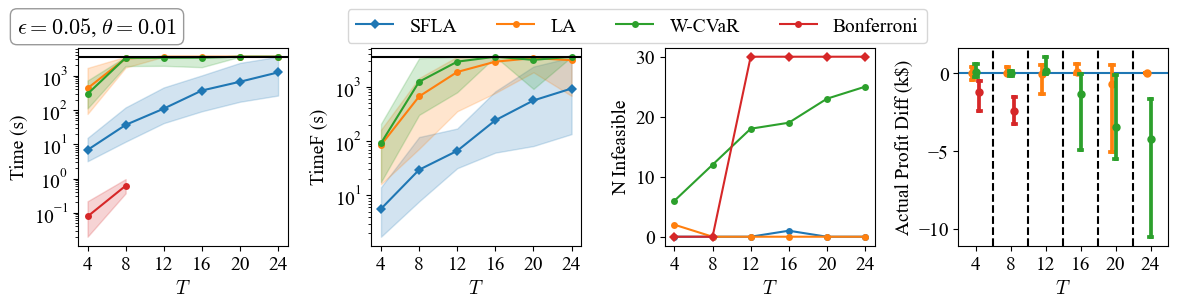

In [13]:
markers = ['D', 'o', 'o', 'o']  # Different markers for each line
line_styles = [(1, 0), (1, 0), (1, 0), (1, 0)]

# make a plot for the following two parameters
theta = 0.01
epsilon = 0.05
N = N_WDR_list[0]

# Ensure 'method' is a string or categorical to avoid type errors
res_all_df_plot = res_all_df[(res_all_df['eps'] == epsilon) & 
                             (res_all_df['theta'] == theta) & 
                             (res_all_df['N'] == N)].copy()

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# Plot for 'computing_time'
ax = axs[0]
sns.lineplot(x='T', y='computing_time', data=res_all_df_plot, ax=ax, 
             hue='method', estimator='mean', errorbar=('pi', 95), style='method', markers=markers, dashes=line_styles, markersize=5, markeredgewidth=0)

ax.set_ylabel('Time (s)')
# set xlabel to be T and (a) on the bottom
ax.set_xlabel('$T$')

ax.set_yscale('log')
ax.set_xticks(res_all_df_plot['T'].unique())
# Do not display the legend within the subplot
ax.get_legend().remove()
# set the minimum y limit to be 0
# ax.set_ylim(bottom=0)
# plot a horizontal line at the timelimit
ax.axhline(y=timelimit, color='black', linestyle='-')

# Plot for 'computing_time_F'
ax = axs[1]
# remove Bonferroni
res_all_df_plot_F = res_all_df_plot[res_all_df_plot['method'] != 'Bonferroni']
sns.lineplot(x='T', y='computing_time_F', data=res_all_df_plot_F, ax=ax, 
             hue='method', estimator='mean', errorbar=('pi', 95), style='method', markers=markers, dashes=line_styles, markersize=5, markeredgewidth=0)
ax.set_ylabel('TimeF (s)')
ax.set_xlabel('$T$')
ax.set_yscale('log')
ax.set_xticks(res_all_df_plot_F['T'].unique())
# Do not display the legend within the subplot
ax.get_legend().remove()
ax.axhline(y=timelimit, color='black', linestyle='-')

ax = axs[2]
# Plot for the number of infeasible cases

res_all_df_plot_infea = res_all_df_plot.copy()
res_all_df_plot_infea['infea'] = 1 - res_all_df_plot_infea['status'].isin(['OPTIMAL', 'TIME_LIMIT'])
res_all_df_plot_infea = res_all_df_plot_infea.groupby(['T', 'method'])['infea'].sum().reset_index()

hue_order = res_all_df_plot['method'].unique()
sns.lineplot(x='T', y='infea', data=res_all_df_plot_infea, ax=ax, 
             hue='method', style='method', markers=markers, hue_order=hue_order, dashes=line_styles, markersize=5, markeredgewidth=0)

ax.set_xlabel('$T$')
ax.set_ylabel('N Infeasible')
ax.set_xticks(res_all_df_plot['T'].unique())
# Do not display the legend within the subplot
ax.get_legend().remove()


# Plot for 'exact_profit'
ax = axs[3]

res_all_df_plot_1 = res_all_df_plot[res_all_df_plot['method'] != 'SFLA']
# start from the second color
new_palette = sns.color_palette("tab10")[1:]

sns.pointplot(x='T', y='exact_profit_minus_prop', data=res_all_df_plot_1, ax=ax, 
             hue='method', dodge=.2, estimator= 'mean', markers=['o', 'o', 'o'], linestyle='none', errorbar=('pi', 95), zorder=10, capsize = .1, markersize=4, palette=new_palette)
# add verticle lines to separate the T
for _ in range(0, len(res_all_df_plot['T'].unique())-1):
    ax.axvline(_+.5, color='black', linestyle='--')
ax.axhline(0, color=sns.color_palette("tab10")[0], linestyle='-')

ax.set_xlabel('$T$')
ax.set_ylabel('Actual Profit Diff (k$)')
# Do not display the legend within the subplot
ax.get_legend().remove()

# add a supertitle
fig.suptitle('')

# Create custom legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.54, 1.02), ncol=4)
# add text on top of the figure
fig.text(0.09, 0.93, fr'$\epsilon={epsilon}$, $\theta={theta}$', ha='center', va='center', fontsize=16, bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.2, wspace=0.4)

# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'bilevel_eps{epsilon}_theta{theta}_N{N}_FGap{FGap}.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)

In [10]:
# count the total number of infeasible runs for each methods for all the parameters
res_all_df_infea_tot = res_all_df.copy()
res_all_df_infea_tot['infea'] = 1 - res_all_df_infea_tot['status'].isin(['OPTIMAL', 'TIME_LIMIT'])
res_all_df_infea_tot = res_all_df_infea_tot.groupby(['method'])['infea'].sum().reset_index()
res_all_df_infea_tot

,method,infea
0,Bonferroni,630
1,LA,22
2,SFLA,1
3,W-CVaR,463
